In [63]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [64]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [65]:
import re
from datetime import datetime,timedelta
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import traceback
import itertools
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import pytz
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

In [66]:
my_data=pd.read_csv("ALLDATA.csv")
forex=pd.read_csv("AUDUSD.csv")
forex["Date"]=forex["Date"].map(str)+":00"
forex=forex.set_index(["Date"])
my_data=my_data.set_index(["Date"])
my_data=my_data.join(forex,rsuffix="|FX|")
my_data=my_data.ffill()
my_data["BID|FX"]=my_data["Close"]
my_data["ASK|FX"]=my_data["Close"]+0.00005
my_data=my_data.drop(['Open','High','Low','Close'],axis=1)
my_data=my_data.sort_index()
for x in ['AU3','AU10','FX','US10','US5','US30']:
    my_data['MID|'+str(x)]=0.5*(my_data['ASK|'+str(x)]+my_data['BID|'+str(x)])
    my_data["RETURN|"+str(x)]=my_data["MID|"+str(x)].pct_change()
my_data=my_data.reset_index()

In [67]:

i=0
for x in ['AU3','AU10','FX','US10','US5','US30']:
    i+=1
    plt.subplot(3,2,i)
    plt.title(str(x))
    plt.plot(my_data['MID|'+str(x)])
plt.show()

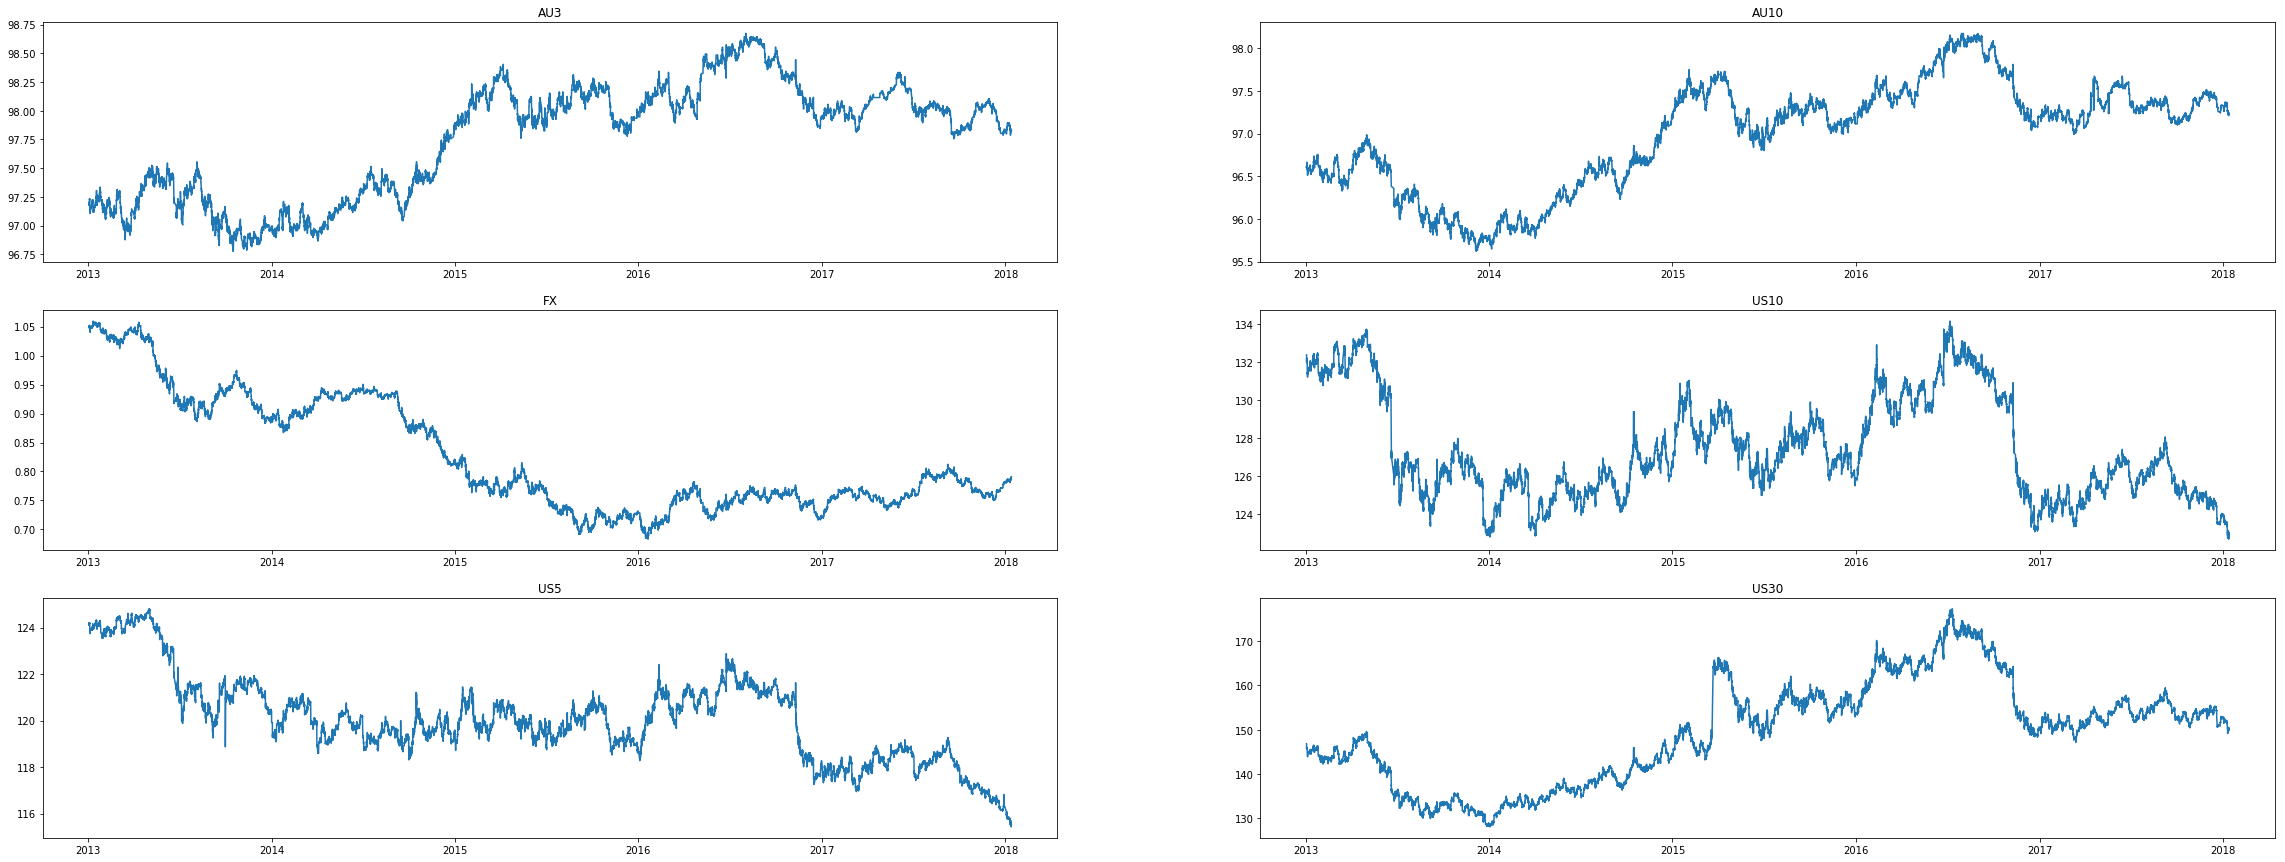

In [68]:
# CREATEE BARS

#BID ASK FOR EACH 

my_data=my_data[['Date', 'BID|US10', 'ASK|US10', 'USLOCAL', 'BID|US30', 'ASK|US30',
       'BID|US5', 'ASK|US5', 'BID|AU10', 'BID|AU3', 'ASK|AU10', 'ASK|AU3',
       'AUSLOCAL', 'MID|US30','AUSROLL', 'USROLL', 'BID|FX', 'ASK|FX']]
my_data["Date"]=pd.to_datetime(my_data["Date"])

my_data=my_data.set_index("Date")
index_list=[]
for x in ["AU10","AU3","US5","US10","US30","FX"]:
    for y in ["BID","ASK"]:
         
        item=(my_data[str(y)+"|"+str(x)].resample('1H',label='right',closed='right').ohlc().index)
        index_list.append(item)
flat_list = list(set([item for sublist in index_list for item in sublist]))

new_frame=pd.DataFrame(index=flat_list)
new_frame=new_frame.sort_index()



new_frame["close"]=0
for x in ["AU10","AU3","US5","US10","US30","FX"]:
    for y in ["BID","ASK"]:
         
        dff=(my_data[str(y)+"|"+str(x)].resample('1H',label='right',closed='right').ohlc())
        dff=dff["close"]
        new_frame=new_frame.join(dff,rsuffix=str(y)+"|"+str(x))
        


my_data["TT"]=my_data.index
my_data["TT"]=my_data["TT"].astype(str).str.split(" ",expand=True)[0]
my_data=my_data.reset_index()
my_data=my_data.set_index(my_data["TT"])



new_frame["TT"]=new_frame.index
new_frame["TT"]=new_frame["TT"].astype(str).str.split(" ",expand=True)[0]
new_frame=new_frame.reset_index()
new_frame=new_frame.set_index(new_frame["TT"])

my_datas=my_data.copy()
my_datas=my_datas[["AUSROLL","USROLL"]]
my_datas = my_datas[~my_datas.index.duplicated(keep='first')]



new_frame=new_frame.join(my_datas)

new_frame=new_frame.dropna()
new_frame=new_frame.set_index(new_frame["index"])
new_frame=new_frame.drop(["TT"],axis=1)
new_frame=new_frame.sort_index()
new_cols=[x.replace("close","") for x in new_frame.columns]
new_frame.columns=new_cols
for x in ['AU3','AU10','FX','US10','US5','US30']:
    new_frame['MID|'+str(x)]=0.5*(new_frame['ASK|'+str(x)]+new_frame['BID|'+str(x)])
    new_frame['RET|'+str(x)]=np.log(new_frame['MID|'+str(x)]).diff()


plt.figure(figsize=(40,15))
i=0
for x in ['AU3','AU10','FX','US10','US5','US30']:
    i+=1
    plt.subplot(3,2,i)
    plt.title(str(x))
    plt.plot(new_frame['MID|'+str(x)])
plt.show()

new_frame=new_frame.dropna()

new_frame["indexshift"]=new_frame["index"].shift(1)
new_frame["idiff"]=new_frame["index"]-new_frame["indexshift"]
new_frame["LEGITDIFF"]=0
new_frame["LEGITDIFF"]=np.where(new_frame["idiff"]<=timedelta(hours=1),1,0)
new_frame=new_frame.drop(["indexshift","idiff"],axis=1)

new_frame["AUR"]=(new_frame["MID|AU3"]-new_frame["MID|AU10"])/new_frame["MID|AU3"]
new_frame["USR1"]=(new_frame["MID|US5"]-new_frame["MID|US10"])/new_frame["MID|US10"]
new_frame["USR2"]=(new_frame["MID|US10"]-new_frame["MID|US30"])/new_frame["MID|US30"]

plt.figure(figsize=(40,15))
plt.plot(((new_frame["AUR"]/new_frame["USR"])*(1/new_frame["MID|FX"])-(new_frame["AUR"]/new_frame["USR"])))
#plt.plot(new_frame["MID|US5"]-2*new_frame["MID|US10"]+new_frame["MID|US30"])
plt.show()

In [69]:
def calculate_tick_value_3s(y):
    z=y+0.01

    payments=6
    coupon=3
    i=(100-y)/200
    v=np.round(1/(1+i),8)
    d1=1000*np.round(coupon*(1-np.round(v**payments,8))/i+100*np.round(v**payments,8),8)

    
    i=(100-z)/200
    v=np.round(1/(1+i),8)
    d2=1000*np.round(coupon*(1-np.round(v**payments,8))/i+100*np.round(v**payments,8),8)    
    return np.round(d2-d1,2)
def calculate_tick_value_10s(y):
    z=y+0.01

    payments=20
    coupon=3
    i=(100-y)/200
    v=np.round(1/(1+i),8)
    d1=1000*np.round(coupon*(1-np.round(v**payments,8))/i+100*np.round(v**payments,8),8)
    
    i=(100-z)/200
    v=np.round(1/(1+i),8)
    d2=1000*np.round(coupon*(1-np.round(v**payments,8))/i+100*np.round(v**payments,8),8)    
    return np.round(d2-d1,2)

new_frame["TICK|AU3"]=new_frame["MID|AU3"].apply(calculate_tick_value_3s)*new_frame["MID|FX"]
new_frame["TICK|AU10"]=new_frame["MID|AU10"].apply(calculate_tick_value_10s)*new_frame["MID|FX"]
new_frame["TICK|US5"]=new_frame["TICK|US10"]=new_frame["TICK|US30"]=31.25


new_frame["TH|US5"]=new_frame["TH|US10"]=new_frame["TH|US30"]=new_frame["TH|AU10"]=new_frame["TH|AU3"]=0
new_frame["TH|US5"]=new_frame["MID|US5"].diff()/(1/32)*new_frame["TICK|US5"]
new_frame["TH|US10"]=new_frame["MID|US10"].diff()/(1/32)*new_frame["TICK|US10"]
new_frame["TH|US30"]=new_frame["MID|US30"].diff()/(1/32)*new_frame["TICK|US30"]
new_frame["TH|AU3"]=new_frame["MID|AU3"].diff()/(0.01)*new_frame["TICK|AU3"]
new_frame["TH|AU10"]=new_frame["MID|AU10"].diff()/(0.01)*new_frame["TICK|AU10"]
new_frame=new_frame.dropna()

constant=25000
new_frame["TH|US5"]=new_frame["TH|US5"].cumsum()+constant
new_frame["TH|US10"]=new_frame["TH|US10"].cumsum()+constant
new_frame["TH|US30"]=new_frame["TH|US30"].cumsum()+constant
new_frame["TH|AU3"]=new_frame["TH|AU3"].cumsum()+constant
new_frame["TH|AU10"]=new_frame["TH|AU10"].cumsum()+constant
plt.figure(figsize=(40,15))
i=0
for x in ['AU3','AU10','US10','US5','US30']:
    i+=1
    plt.subplot(3,2,i)
    plt.title(str(x))
    plt.plot(new_frame['TH|'+str(x)])
plt.show()

for x in ['AU3','AU10','US10','US5','US30']:
    new_frame['RETH|'+str(x)]=np.log(new_frame['TH|'+str(x)]).diff()
new_frame=new_frame.dropna()

In [183]:


pred_frame=new_frame.copy()
pred_frame=pred_frame[pred_frame["LEGITDIFF"]==1]


pred_frame["COEF|US10"]=np.nan



#ONE DAY is 20 Hours
LOOKBACK_YEARS=[3/12]
LOOKFORWARD=20
for LB in LOOKBACK_YEARS:
    print("-"*100)
    LOOKBACK=int(21*20*12*LB)
    print("LOOKBACK :",LOOKBACK/(21*20*12)," years")
    fin_list=[]
    
    iii=0
    for x in range(len(pred_frame)-LOOKBACK):

        iii+=1

        my_slice=pred_frame.iloc[0+x:0+x+LOOKBACK]
 
        
        #all_frame=new_frame.iloc[0+x:0+x+LOOKBACK+LOOKFORWARD]
        #regress_slice=my_slice
        rsq=0
        combin=["RETH|US10"]

        X = my_slice[[x for x in combin]]
        Y = my_slice["RETH|AU10"]
        
        model = sm.OLS(Y, X).fit()
        model_index=my_slice.index[-1]


        for ind in list(model.params.index):
            pred_frame.loc[str(model_index),"COEF|"+ind.split('|')[1]]=model.params[ind]

        #rsq=model.rsquared_adj
         
    #   prediction=model.predict(all_frame[[x for x in combin]])
        
    
        #item=[my_slice.index[-1],model.params[0],model.params[1],model.params[2],rsq]
        
     #   ll=(((np.exp(prediction+np.log(all_frame["TH|AU10"].shift(1)))-constant).diff())*0.01)/(all_frame["TICK|AU10"]/all_frame["MID|FX"])+all_frame["MID|AU10"].shift(1)

       # my_pred=(ll.iloc[0+x+LOOKBACK])
     #   ll.loc[""]
        if iii%1000==0:
            print(x/(len(pred_frame)))
 
        
            
        







----------------------------------------------------------------------------------------------------
LOOKBACK : 0.25  years
0.037176242929443284
0.07438969931527241
0.11160315570110152
0.14881661208693064
0.18603006847275974
0.22324352485858887
0.26045698124441796
0.2976704376302471
0.3348838940160762
0.37209735040190534
0.40931080678773446
0.4465242631735636
0.48373771955939265
0.5209511759452218
0.558164632331051
0.59537808871688
0.6325915451027091
0.6698050014885383
0.7070184578743673
0.7442319142601965
0.7814453706460256
0.8186588270318547
0.8558722834176838
0.8930857398035129
0.9302991961893421


In [185]:
#when it converges given the residual size
# quantile of residual
# convergence value

#same stuff for 3s
pred_frame.dropna().to_csv("ForecastAU.csv")

In [182]:
pred_frame

index     BID|AU10  ASK|AU10  BID|AU3  \
index                                                                     
2013-01-02 13:00:00 2013-01-02 13:00:00  0    96.610   96.6150   97.190   
2013-01-02 14:00:00 2013-01-02 14:00:00  0    96.600   96.6100   97.180   
2013-01-02 15:00:00 2013-01-02 15:00:00  0    96.625   96.6300   97.200   
2013-01-02 16:00:00 2013-01-02 16:00:00  0    96.610   96.6150   97.180   
2013-01-02 17:00:00 2013-01-02 17:00:00  0    96.615   96.6250   97.200   
2013-01-02 18:00:00 2013-01-02 18:00:00  0    96.615   96.6200   97.180   
2013-01-02 19:00:00 2013-01-02 19:00:00  0    96.610   96.6150   97.180   
2013-01-02 20:00:00 2013-01-02 20:00:00  0    96.615   96.6200   97.180   
2013-01-03 01:00:00 2013-01-03 01:00:00  0    96.615   96.6200   97.180   
2013-01-03 02:00:00 2013-01-03 02:00:00  0    96.630   96.6350   97.200   
2013-01-03 03:00:00 2013-01-03 03:00:00  0    96.635   96.6400   97.200   
2013-01-03 04:00:00 2013-01-03 04:00:00  0    96.635   96.6400   97.200   
2013-01-03 05:00:00 2013-01-03 05:00:00  0    96.650   96.6550   97.220   
2013-01-03 06:00:00 2013-01-03 06:00:00  0    96.660   96.6625   97.220   
2013-01-03 07:00:00 2013-01-03 07:00:00  0    96.650   96.6550   97.220   
2013-01-03 08:00:00 2013-01-03 08:00:00  0    96.655   96.6600   97.230   
2013-01-03 09:00:00 2013-01-03 09:00:00  0    96.655   96.6600   97.220   
2013-01-03 10:00:00 2013-01-03 10:00:00  0    96.650   96.6550   97.220   
2013-01-03 11:00:00 2013-01-03 11:00:00  0    96.660   96.6650   97.230   
2013-01-03 12:00:00 2013-01-03 12:00:00  0    96.660   96.6700   97.230   
2013-01-03 13:00:00 2013-01-03 13:00:00  0    96.660   96.6650   97.230   
2013-01-03 14:00:00 2013-01-03 14:00:00  0    96.645   96.6500   97.220   
2013-01-03 15:00:00 2013-01-03 15:00:00  0    96.630   96.6350   97.210   
2013-01-03 16:00:00 2013-01-03 16:00:00  0    96.610   96.6150   97.200   
2013-01-03 17:00:00 2013-01-03 17:00:00  0    96.605   96.6100   97.180   
2013-01-03 18:00:00 2013-01-03 18:00:00  0    96.600   96.6050   97.180   
2013-01-03 19:00:00 2013-01-03 19:00:00  0    96.605   96.6100   97.180   
2013-01-03 20:00:00 2013-01-03 20:00:00  0    96.570   96.5750   97.150   
2013-01-04 01:00:00 2013-01-04 01:00:00  0    96.570   96.5725   97.140   
2013-01-04 02:00:00 2013-01-04 02:00:00  0    96.570   96.5750   97.150   
...                                 ... ..       ...       ...      ...   
2018-01-11 11:00:00 2018-01-11 11:00:00  0    97.260   97.2650   97.830   
2018-01-11 12:00:00 2018-01-11 12:00:00  0    97.265   97.2700   97.835   
2018-01-11 13:00:00 2018-01-11 13:00:00  0    97.245   97.2500   97.825   
2018-01-11 14:00:00 2018-01-11 14:00:00  0    97.240   97.2450   97.815   
2018-01-11 15:00:00 2018-01-11 15:00:00  0    97.230   97.2350   97.810   
2018-01-11 16:00:00 2018-01-11 16:00:00  0    97.240   97.2450   97.810   
2018-01-11 17:00:00 2018-01-11 17:00:00  0    97.245   97.2475   97.820   
2018-01-11 18:00:00 2018-01-11 18:00:00  0    97.250   97.2550   97.820   
2018-01-11 19:00:00 2018-01-11 19:00:00  0    97.250   97.2550   97.820   
2018-01-11 20:00:00 2018-01-11 20:00:00  0    97.250   97.2550   97.825   
2018-01-12 01:00:00 2018-01-12 01:00:00  0    97.245   97.2500   97.825   
2018-01-12 02:00:00 2018-01-12 02:00:00  0    97.240   97.2450   97.825   
2018-01-12 03:00:00 2018-01-12 03:00:00  0    97.250   97.2550   97.835   
2018-01-12 04:00:00 2018-01-12 04:00:00  0    97.245   97.2500   97.830   
2018-01-12 05:00:00 2018-01-12 05:00:00  0    97.240   97.2450   97.825   
2018-01-12 06:00:00 2018-01-12 06:00:00  0    97.240   97.2450   97.825   
2018-01-12 07:00:00 2018-01-12 07:00:00  0    97.235   97.2400   97.830   
2018-01-12 08:00:00 2018-01-12 08:00:00  0    97.235   97.2400   97.830   
2018-01-12 09:00:00 2018-01-12 09:00:00  0    97.240   97.2450   97.835   
2018-01-12 10:00:00 2018-01-12 10:00:00  0    97.240   97.2450   97.830   
2018-01-12 11:00:00 2018-01-12 11:00:00  0    97.240   97.2

In [123]:
plt.plot(pred_frame.dropna()["COEF|AU3"])
plt.plot(pred_frame.dropna()["COEF|US5"])
plt.plot(pred_frame.dropna()["COEF|US10"])
plt.show()


3*100+2*80)

460

In [172]:


def backtest_price(bnd,TIME_EXIT,lkbk,MAX_LOOP,COMMS_MULTIPLIER):
    model = LinearRegression()


#features = np.asarray([new_frame['TH|'+str(x)] for i,x in enumerate(['AU3','US10','AU10','US30'])])
    features = np.asarray([new_frame['MID|'+str(x)] for i,x in enumerate(['US10'])])
    classifier = np.asarray(new_frame['MID|US5'])

    datesss=np.asarray(new_frame.index)

    inpos = 0
    cnt = 10000
    
    pnls = []
    dates = []
    residual=0
    curr_price=0
    op=0
    com_list=[]
    entry=0
    ttt=0
    stds=[]
    #costs=[31*0.9+(1.6*2),16+(1.6*2),50*0.9+3.2,32+(1.6*2)]
    #costs=[16+(1.6*2)+31.25+(1.6*2)]    
    costs=[32+(1.6*2)]  
    #costs=[0]
    for i in range(lkbk+1,classifier.shape[0]-4):
        cnt += 1
        if not inpos and cnt>MAX_LOOP:
            
            ft = features[:,i-lkbk:i]
            cl = classifier[i-lkbk:i]

            #testtt=[ft,cl]
            #return testtt
            model.fit(ft.T,cl)
            bw = np.std(residual)
            
            comissions_=(np.sum(np.array(costs)*np.abs(model.coef_))+(8+(1.6*2)))/(31.25)
            comissions=0.5
            #comissions=0
            comissions_real=comissions_*31.25*0.25
            
            #comissions_real=0
            pos = 1#(np.abs(curr_price)/bw)
       
            
            cnt = 0
            
        if i>lkbk+3:
            curr_price = (np.sum(model.coef_*features[:,i])-classifier[i]+model.intercept_)
      
            residual = (np.sum(model.coef_*features[:,i-lkbk:i].T,axis=1)-classifier[i-lkbk:i]+model.intercept_)
            stds.append(curr_price)
            #print(bw,curr_price)
            #print(datesss[i],curr_price,bw*bnd)
            '''
            print("Curr Residual")
            print(curr_price)
            print("Bandwidth")
            print(bw*bnd)
            '''
        if curr_price > bw*bnd and inpos == 0 and curr_price>comissions:
                inpos = -1
                #print('short enter ',datesss[i])
                print(model.coef_)
                entry = curr_price
                op = i           

        elif (i-op>TIME_EXIT and inpos==-1) or (inpos == -1 and (curr_price < -entry-comissions*COMMS_MULTIPLIER)):
            inpos = 0
            pnl = (-curr_price + entry)*pos*31.25

           # print('short exit',pnl,i-op,comissions,pos,datesss[i])
            #print("-"*100)
            #print(model.coef_)
            pnls.append(pnl-comissions_real*pos)
            dates.append(i)


        elif curr_price < -bw*bnd and inpos == 0  and curr_price<-comissions:
                inpos = 1
                #print('long enter ',datesss[i])
               # print(model.coef_)
                entry = curr_price
                op = i
                entry_limit=-bw*bnd

        elif (i-op>TIME_EXIT and inpos==1) or (inpos == 1 and (curr_price > entry+comissions*COMMS_MULTIPLIER)):
            inpos = 0
            pnl = (curr_price - entry)*pos*31.25

            #print('long exit',pnl,i-op,comissions,pos,datesss[i],"entry:",entry,"exit:",curr_price,"entry_limit:",entry_limit)
            #print("-"*100)
            pnls.append(pnl-comissions_real*pos) 
            dates.append(i)
        #if i<350:
            #print(datesss[i],inpos,curr_price,comissions,entry,bw*bnd)
            
        #res_raw = np.sum(basket_price,axis=1) - cl[-start:] + model.intercept_
    plt.plot(stds)
    plt.show()
    return dates,pnls


1 314 310 132 1.6971431742693217
[0.4192321]
[0.80327606]
[0.30235182]
[0.32538824]
[0.16887195]
[0.78614939]
[0.39423942]
[0.47580286]
[0.10464157]
[0.17342473]
[0.39000631]
[0.41113908]


25


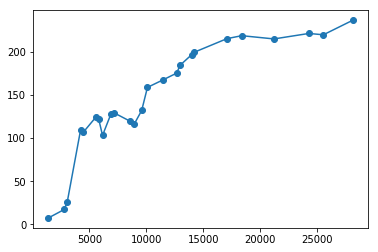

9.465096967741093

In [173]:


for _ in range(1):
    tls =[]
    for bnd in range(1,2):
        
        aa=np.random.randint(100,500)
        bb=np.random.randint(100,500)
        cc=np.random.randint(50,200)
        dd=np.random.rand()*1.5+1
        print(bnd,aa,bb,cc,dd)
        #dates,pnls = backtest(bnd,aa,bb,cc,dd)
        dates,pnls = backtest_price(1,236,288,136,1.1333257746892431)
        #dates,pnls = backtest_price(bnd=1,TIME_EXIT=10,lkbk=252,MAX_LOOP=10,COMMS_MULTIPLIER=1.5)

        #testttt = backtest(bnd,aa,bb,cc,dd)
        #mesttt=backtest_yigit(new_frame,bnd,aa,bb,cc,dd)
        #print(testttt[0]==mesttt[0])
        #print(testttt[1]==mesttt[1])
  
        tls.append(pd.Series(pnls,index=dates))
        print(len(pnls))


    df = pd.DataFrame(tls)
    plt.plot(df.sum(axis=0).cumsum(),'-o')
plt.show()

#print(datesss[i],inpos,curr_price,comissions,entry,bw*bnd)
#print(nowtime_utc,inpos,curr_price,comissions,entry,bw*BND)
'''
2013-01-22 09:00:00 0 12.768896759751442 29.859821141262405 0 0.0
2013-01-22 10:00:00 0 16.14979045601649 29.859821141262405 0 0.0
2013-01-22 11:00:00 0 9.159247189645612 29.859821141262405 0 0.0
2013-01-22 12:00:00 0 26.899848214196027 29.859821141262405 0 0.0
2013-01-22 13:00:00 0 25.849135606724303 29.859821141262405 0 0.0
2013-01-22 14:00:00 -1 35.14150834267275 29.859821141262405 35.14150834267275 0.0
2013-01-22 15:00:00 -1 15.921034582173888 29.859821141262405 35.14150834267275 0.0
2013-01-22 16:00:00 -1 25.145562762070767 29.859821141262405 35.14150834267275 0.0
2013-01-22 17:00:00 -1 28.755212332176598 29.859821141262405 35.14150834267275 0.0
2013-01-22 18:00:00 -1 13.130212332176598 29.859821141262405 35.14150834267275 0.0
2013-01-22 19:00:00 -1 15.245813356727012 29.859821141262405 35.14150834267275 0.0
2013-01-22 20:00:00 -1 4.363195899963102 29.859821141262405 35.14150834267275 0.0
2013-01-23 00:00:00 -1 10.585451179149459 29.859821141262405 35.14150834267275 0.0
2013-01-23 01:00:00 -1 11.636163786621182 29.859821141262405 35.14150834267275 0.0
2013-01-23 02:00:00 -1 0.7535463298572722 29.859821141262405 35.14150834267275 0.0
2013-01-23 03:00:00 -1 -0.8225225813530415 29.859821141262405 35.14150834267275 0.0
2013-01-23 04:00:00 -1 5.939264811175235 29.859821141262405 35.14150834267275 0.0
2013-01-23 05:00:00 -1 4.888552203699874 29.859821141262405 35.14150834267275 0.0
2013-01-23 06:00:00 -1 12.390275964202374 29.859821141262405 35.14150834267275 0.0
2013-01-23 07:00:00 -1 23.058313356727012 29.859821141262405 35.14150834267275 0.0
2013-01-23 08:00:00 -1 17.886770685016018 29.859821141262405 35.14150834267275 0.0
2013-01-23 09:00:00 -1 13.765940620778565 29.859821141262405 35.14150834267275 0.0
2013-01-23 10:00:00 -1 25.159738571674097 29.859821141262405 35.14150834267275 0.0
2013-01-23 11:00:00 -1 13.226408507434826 29.859821141262405 35.14150834267275 0.0
2013-01-23 12:00:00 -1 5.413908507434826 29.859821141262405 35.14150834267275 0.0
2013-01-23 13:00:00 -1 12.701052203699874 29.859821141262405 35.14150834267275 0.0
2013-01-23 14:00:00 -1 32.36486190228243 29.859821141262405 35.14150834267275 0.0
2013-01-23 15:00:00 -1 10.503430813492741 29.859821141262405 35.14150834267275 0.0
2013-01-23 16:00:00 -1 31.314149294810704 29.859821141262405 35.14150834267275 0.0
2013-01-23 17:00:00 -1 33.319378334494104 29.859821141262405 35.14150834267275 0.0
2013-01-23 18:00:00 -1 46.82877730994369 29.859821141262405 35.14150834267275 0.0










'''


np.mean(pnls)



In [150]:
def backtest_yigit(frame,BND,TIME_EXIT,LOOKBACK,MAX_LOOP,COMMS_MULTIPLIER):
    model_counter=100000
    residual=0
    pnls = []
    dates = []
    residual=0
    curr_price=0
    op=0
    inpos=0
    com_list=[]
    #costs=[31*0.9+(1.6*2),16+(1.6*2),50*0.9+3.2,32+(1.6*2)]
    costs=[16+(1.6*2),32+(1.6*2)]
    final_list=[]
    entry=0
    ttt=0
    stds=[]
    for x in range(2,len(frame)-LOOKBACK):
        model_counter += 1
        my_slice=frame.iloc[0+x:0+x+LOOKBACK,:]
        nowtime_utc=my_slice.index[-1]
        
        reg_slice=frame.iloc[0+x-1:0+x+LOOKBACK-1,:]
        nowtime_us=nowtime_utc.tz_localize('utc').tz_convert('America/Chicago')
        ft =np.array([reg_slice['TH|'+str(x)] for i,x in enumerate(['US10','US30'])])
        cl =np.array(reg_slice['TH|US5'])
        
        
        if not inpos and model_counter>MAX_LOOP:
            

            
       

            
            model = LinearRegression()
  
            model.fit(ft.T,cl)
            
            comissions=(np.sum(np.array(costs)*np.abs(model.coef_))+(8+(1.6*2)))
            pos = 1#(np.abs(curr_price)/bw)
            #print(model.coef_)
            model_counter=0

            bw = np.std(residual)

        
        curr_price = (model.coef_[0]*my_slice["TH|US10"].iloc[-1])+(model.coef_[1]*my_slice["TH|US30"].iloc[-1])-my_slice["TH|US5"].iloc[-1]+model.intercept_    
        residual = np.sum(model.coef_*ft.T,axis=1)-cl+model.intercept_         
        stds.append(curr_price)
        if curr_price > bw*BND and inpos == 0 and curr_price>comissions:
            inpos = -1
            entry=curr_price
            op = x
            
            US10_ENTRYLOTS=(model.coef_)[0]
            US30_ENTRYLOTS=(model.coef_)[1]
            US5_ENTRYLOTS=1
            
            entry_time_utc=nowtime_utc
            entry_time_local=nowtime_us
            
            if US10_ENTRYLOTS*-1>0:
                US10_ENTRY=my_slice["ASK|US10"].iloc[-1]
            else:
                US10_ENTRY=my_slice["BID|US10"].iloc[-1]
                
            if US30_ENTRYLOTS*-1>0: 
                US30_ENTRY=my_slice["ASK|US30"].iloc[-1]
            else:
                US30_ENTRY=my_slice["BID|US30"].iloc[-1] 

            
            US5_ENTRY=my_slice["ASK|US30"].iloc[-1]
            '''
            print("enter Short")
            print("10 Spread:",(my_slice["ASK|US10"].iloc[-1]-my_slice["BID|US10"].iloc[-1])/(1/32)*31.25)
            print("5 Spread:",(my_slice["ASK|US5"].iloc[-1]-my_slice["BID|US5"].iloc[-1])/(1/32)*31.25)    
            print("30 Spread:",(my_slice["ASK|US30"].iloc[-1]-my_slice["BID|US30"].iloc[-1])/(1/32)*31.25)    
            '''
            #SELL US10, SELL US 30 , BUY US5
            
        elif (x-op>TIME_EXIT and inpos==-1) or (inpos == -1 and (curr_price < -entry-comissions*COMMS_MULTIPLIER)):
            inpos = 0
            pnl = (-curr_price + entry)*pos
            
            if US10_ENTRYLOTS*-1>0:
                US10_EXIT=my_slice["BID|US10"].iloc[-1]
            else:
                US10_EXIT=my_slice["ASK|US10"].iloc[-1]
                
            if US30_ENTRYLOTS*-1>0: 
                US30_EXIT=my_slice["BID|US30"].iloc[-1]
            else:
                US30_EXIT=my_slice["ASK|US30"].iloc[-1]

            
            US5_EXIT=my_slice["BID|US30"].iloc[-1]  
            
            US10_profit=(US10_EXIT-US10_ENTRY)/(1/32)*31.25*US10_ENTRYLOTS*-1
            US30_profit=(US30_EXIT-US30_ENTRY)/(1/32)*31.25*US30_ENTRYLOTS*-1
            US5_profit=(US5_EXIT-US5_ENTRY)/(1/32)*31.25*US5_ENTRYLOTS
    #         print('short exit',pnl,i-op,comissions,pos)
            my_com=1.6*(np.abs(US10_ENTRYLOTS)+np.abs(US30_ENTRYLOTS)+np.abs(US5_ENTRYLOTS))*2

            item=["SHORT",entry_time_utc,entry_time_local,nowtime_utc,nowtime_us,US10_ENTRY,US30_ENTRY,US5_ENTRY,US10_EXIT,US30_EXIT,US5_EXIT,US10_profit,US30_profit,US10_profit,my_com,US10_ENTRYLOTS,US30_ENTRYLOTS,US5_ENTRYLOTS]
            final_list.append(item)
            pll=US10_profit+US5_profit+US30_profit-my_com
  
            '''
            print("exit Short",x-op)
            print("10 Spread:",(my_slice["ASK|US10"].iloc[-1]-my_slice["BID|US10"].iloc[-1])/(1/32)*31.25)
            print("5 Spread:",(my_slice["ASK|US5"].iloc[-1]-my_slice["BID|US5"].iloc[-1])/(1/32)*31.25)    
            print("30 Spread:",(my_slice["ASK|US30"].iloc[-1]-my_slice["BID|US30"].iloc[-1])/(1/32)*31.25)  
            print("Profit: ",pll)
            print('-'*100)
            '''
        elif curr_price < -bw*BND and inpos == 0  and curr_price<-comissions:
            inpos = 1
            #print('long enter')
            entry = curr_price
            op = x
            
            entry_time_utc=nowtime_utc
            entry_time_local=nowtime_us
            
            US10_ENTRYLOTS=(model.coef_)[0]
            US30_ENTRYLOTS=(model.coef_)[1]
            US5_ENTRYLOTS=1
            
            if US10_ENTRYLOTS>0:
                US10_ENTRY=my_slice["ASK|US10"].iloc[-1]
            else:
                US10_ENTRY=my_slice["BID|US10"].iloc[-1]
                
            if US30_ENTRYLOTS>0: 
                US30_ENTRY=my_slice["ASK|US30"].iloc[-1]
            else:
                US30_ENTRY=my_slice["BID|US30"].iloc[-1]
            
            US5_ENTRY=my_slice["BID|US5"].iloc[-1]
            #print("enter Long")
            

            
            
        elif (x-op>TIME_EXIT and inpos==1) or (inpos == 1 and (curr_price > entry+comissions*COMMS_MULTIPLIER)):
            inpos = 0
            pnl = (curr_price - entry)*pos

    #         print('long exit',pnl,i-op,comissions,pos)
       
            if US10_ENTRYLOTS>0:
                US10_EXIT=my_slice["BID|US10"].iloc[-1]
            else:
                US10_EXIT=my_slice["ASK|US10"].iloc[-1]
                
            if US30_ENTRYLOTS>0: 
                US30_EXIT=my_slice["BID|US30"].iloc[-1]
            else:
                US30_EXIT=my_slice["ASK|US30"].iloc[-1]

            
            
            US5_EXIT=my_slice["ASK|US5"].iloc[-1]  
            
            US10_profit=(US10_EXIT-US10_ENTRY)/(1/32)*31.25*US10_ENTRYLOTS
            US30_profit=(US30_EXIT-US30_ENTRY)/(1/32)*31.25*US30_ENTRYLOTS
            
            US5_profit=(US5_EXIT-US5_ENTRY)/(1/32)*31.25*US5_ENTRYLOTS*-1
    #         print('short exit',pnl,i-op,comissions,pos)
            #print("exit Long",x-op)
            my_com=1.6*(np.abs(US10_ENTRYLOTS)+np.abs(US30_ENTRYLOTS)+np.abs(US5_ENTRYLOTS))*2
            item=["LONG",entry_time_utc,entry_time_local,nowtime_utc,nowtime_us,US10_ENTRY,US30_ENTRY,US5_ENTRY,US10_EXIT,US30_EXIT,US5_EXIT,US10_profit,US30_profit,US5_profit,my_com,US10_ENTRYLOTS,US30_ENTRYLOTS,US5_ENTRYLOTS]
            final_list.append(item)
       # if x<350:
         #   print(nowtime_utc,inpos,curr_price,comissions,entry,bw*BND)
    plt.plot(stds)
    plt.show()
    return final_list

            
        
        
        

In [11]:


def backtest(bnd,TIME_EXIT,lkbk,MAX_LOOP,COMMS_MULTIPLIER):
    model = LinearRegression()


    #features = np.asarray([new_frame['TH|'+str(x)] for i,x in enumerate(['AU3','US10','AU10','US30'])])
    features = np.asarray([new_frame['TH|'+str(x)] for i,x in enumerate(['US10','US30'])])
    classifier = np.asarray(new_frame['TH|US5'])

    datesss=np.asarray(new_frame.index)

    inpos = 0
    cnt = 10000
    
    pnls = []
    dates = []
    residual=0
    curr_price=0
    op=0
    com_list=[]
    entry=0
    ttt=0
    stds=[]
    #costs=[31*0.9+(1.6*2),16+(1.6*2),50*0.9+3.2,32+(1.6*2)]
    costs=[16+(1.6*2),32+(1.6*2)]    
    
    
    for i in range(lkbk+1,classifier.shape[0]-4):
        cnt += 1
        if not inpos and cnt>MAX_LOOP:
            
            ft = features[:,i-lkbk:i]
            cl = classifier[i-lkbk:i]

            #testtt=[ft,cl]
            #return testtt
            model.fit(ft.T,cl)
            bw = np.std(residual)
            comissions=(np.sum(np.array(costs)*np.abs(model.coef_))+(8+(1.6*2)))
            comissions_real=comissions
            pos = 1#(np.abs(curr_price)/bw)
            #print(model.coef_)
            cnt = 0
            
        if i>lkbk+3:
            curr_price = np.sum(model.coef_*features[:,i])-classifier[i]+model.intercept_
      
            residual = np.sum(model.coef_*features[:,i-lkbk:i].T,axis=1)-classifier[i-lkbk:i]+model.intercept_  
            stds.append(curr_price)
            #print(bw,curr_price)
            #print(datesss[i],curr_price,bw*bnd)

        if curr_price > bw*bnd and inpos == 0 and curr_price>comissions:
                inpos = -1
                #print('short enter ',datesss[i])
                
                entry = curr_price
                op = i           

        elif (i-op>TIME_EXIT and inpos==-1) or (inpos == -1 and (curr_price < -entry-comissions*COMMS_MULTIPLIER)):
            inpos = 0
            pnl = (-curr_price + entry)*pos

          #  print('short exit',pnl,i-op,comissions,pos,datesss[i])
            #print("-"*100)
            
            pnls.append(pnl-comissions_real*pos)
            dates.append(i)


        elif curr_price < -bw*bnd and inpos == 0  and curr_price<-comissions:
                inpos = 1
                #print('long enter ',datesss[i])
                entry = curr_price
                op = i


        elif (i-op>TIME_EXIT and inpos==1) or (inpos == 1 and (curr_price > entry+comissions*COMMS_MULTIPLIER)):
            inpos = 0
            pnl = (curr_price - entry)*pos

           # print('long exit',pnl,i-op,comissions,pos,datesss[i])
            #print("-"*100)
            pnls.append(pnl-comissions_real*pos) 
            dates.append(i)
        #if i<350:
            #print(datesss[i],inpos,curr_price,comissions,entry,bw*bnd)

        #res_raw = np.sum(basket_price,axis=1) - cl[-start:] + model.intercept_
    plt.plot(stds)
    plt.show()
    return dates,pnls



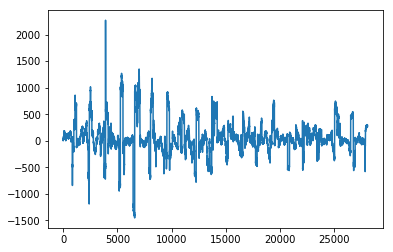

213


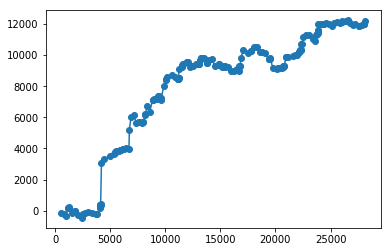

In [12]:
for _ in range(1):
    tls =[]
    for bnd in range(1):
        
        aa=np.random.randint(100,500)
        bb=np.random.randint(100,500)
        cc=np.random.randint(50,200)
        dd=np.random.rand()*1.5+1
        #print(bnd,aa,bb,cc,dd)
        #dates,pnls = backtest(bnd,aa,bb,cc,dd)
        dates,pnls = backtest(1,236,288,136,1.1333257746892431)
        #dates,pnls = backtest(bnd=1,TIME_EXIT=200,lkbk=1000,MAX_LOOP=100,COMMS_MULTIPLIER=1)

        #testttt = backtest(bnd,aa,bb,cc,dd)
        #mesttt=backtest_yigit(new_frame,bnd,aa,bb,cc,dd)
        #print(testttt[0]==mesttt[0])
        #print(testttt[1]==mesttt[1])
  
        tls.append(pd.Series(pnls,index=dates))
        print(len(pnls))


    df = pd.DataFrame(tls)
    plt.plot(df.sum(axis=0).cumsum(),'-o')
plt.show()

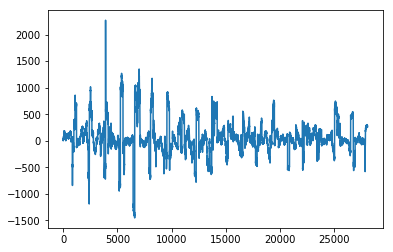

213


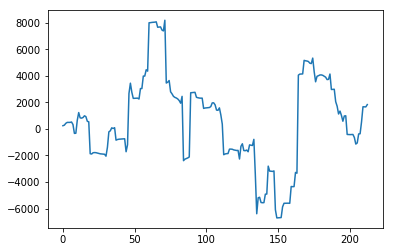

213


In [13]:
flist= backtest_yigit(new_frame,1,236,288,136,1.1333257746892431)
print(len(flist))
collist=["LONG","ENTRY_TIME","entry_time_local","nowtime_utc","nowtime_us","US10_ENTRY","US30_ENTRY","US5_ENTRY","US10_EXIT","US30_EXIT","US5_EXIT","US10_profit","US30_profit","US5_profit","my_com","US10L","US30L","US5L"]
mydf=pd.DataFrame(flist,columns=collist)
zz=(mydf["US10_profit"]+mydf["US5_profit"]+mydf["US30_profit"]-mydf["my_com"])
plt.plot(zz.cumsum())
plt.show()
print(len(mydf))